In [1]:
import os
from pprint import pprint
from pathlib import Path
from copy import deepcopy

import numpy as np
from scipy.constants import pi
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import rcParams
rcParams["font.size"] = 18

from quvac.postprocess import integrate_spherical
from quvac.plotting import plot_mollweide
from quvac.utils import write_yaml, read_yaml

SCRIPT_PATH = '../src/quvac/simulation.py'

path = "../data/tutorials/tutorial_3"
Path(path).mkdir(parents=True, exist_ok=True)

## Run a simulation for two counter-propagating gaussians
As we saw in the previous tutorial, there are several modes for running the simulation script:
- `simulation`: calculates only complex transition amplitudes
- `postprocess`: only postprocesses already calculated transition amplitudes
- `simulation_postprocess`: does both

Here we would run the script in `simulation` mode and then try several postprocessing options on the calculated amplitudes
with `postprocessing` mode.

In [2]:
lam = 800e-9
w0 = 2 * lam
tau = 25e-15

# all parameters in SI units
field_1_params = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "phase0": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": 25,
    "order": 0,
}

# add counter-propagating field
# (it has the same parameters apart from propagation direction and polarization)
field_2_params = deepcopy(field_1_params)
field_2_params["theta"] = 180
field_2_params["beta"] = 45

# combine
fields_params = {
    "field_1": field_1_params,
    "field_2": field_2_params,
}

# grid parameters
grid_params = {
    'mode': 'dynamic',
    'collision_geometry': 'z',
    'transverse_factor': 20,
    'longitudinal_factor': 8,
    'time_factor': 4,
    'spatial_resolution': 1,
    'time_resolution': 1,
}

ini_data = {
    'mode': 'simulation',
    'fields': fields_params,
    'grid': grid_params,
    'integrator': {
        'type': 'vacuum_emission',
    }
}

ini_file = os.path.join(path, 'ini.yml')
write_yaml(ini_file, ini_data)

If this jupyter notebook is run within the environment in which quvac in installed, quvac command line interface should be accessible.

In [3]:
status = os.system(f"quvac-simulation --input {ini_file}")


Timings:
Field setup:                        0.59 s
Vacem setup:                        0.00 s
Amplitudes calculation:            49.97 s
    Per time step:                  0.22 s
Postprocess:                        0.00 s
----------------------------------------------------
Total:                             50.57 s

Memory (max usage):
Amplitudes calculation:          310.06 MB
Total:                           310.06 MB

Simulation finished!


## Postprocessing

`postprocess` section in ini.yml file:
- `perp_polarization_type`: 'optical axis' or 'local axis'
  - 'optical axis': calculates perp signal with respect to the optical axis of `perp_field_idx` field which is calculated from $(\theta, \phi, \beta)$
  - 'local axis': for each k-mode the field orientation is calculated separately, perp signal is calculated with respect to that
- `perp_field_idx`: field index used to calculate the perp signal
- `calculate_spherical`: (bool) interpolate signal on the spherical grid
- `spherical_params`: (dict) parameters for spherical grid calculation
  - `angular_resolution`: angular resolution (in radians)
- `calculate_discernible`: (bool) calculate discernible signal
- `discernibility`: 'angular' or 'spectral'
  - 'angular': signal and background spectra are integrated over frequency and then compared to get discernible regions
  - 'spectral': signal and background spectra are compared on 3d spherical grid
- `stokes`: (bool) calculate stokes vector

Usually one is interested only in a subset of options from the list but we would calculate most of them to take a look.

In [4]:
ini_data = {
    'mode': 'postprocess',
    'fields': fields_params,
    'grid': grid_params,
    'integrator': {
        'type': 'vacuum_emission',
    },
    'postprocess': {
        'perp_polarization_type': 'optical axis',
        'perp_field_idx': 1,
        'calculate_spherical': True,
        'spherical_params': {
                'angular_resolution': 1*np.pi/180.  
        },
        'calculate_discernible': True,
        'discernibility': 'angular',
        'stokes': False
    }
}

ini_file = os.path.join(path, 'ini_postprocess.yml')
write_yaml(ini_file, ini_data)

In [5]:
status = os.system(f"quvac-simulation --input {ini_file}")

/home/maximus/Research/github/quantum-vacuum/src/quvac/postprocess.py:846: UserWarning: WARNING:
Np_total signal on cartesian and spherical grid differ by more than 1%:
    N total (xyz): 21.615
    N total (sph): 21.344

  self.get_signal_on_sph_grid(key="Np_xyz", check_total=True,



Postprocess:
Time:                               3.49 s
----------------------------------------------------
Memory (max usage):              733.55 MB

Simulation finished!


### Check the results

In [6]:
def print_total_numbers(data, data_pol):
    # check total amount of signal
    total_str = """
    ---------------------
    N total:
        xyz grid: {:.2f}
        sph grid: {:.2f}
    ---------------------
    N perp:
        xyz grid: {:.2f}
        sph grid: {:.2f}
    """
    
    total_print = total_str.format(
        data["N_total"],
        data["N_sph_total"],
        data_pol["Np_total"],
        data_pol["Np_sph_total"],
    )
    print(total_print)


def plot_spectra(data, spectrum_key="N_sph"):
    # total signal spectrum on spherical grid
    k, theta, phi, N_sph = [data[key] for key in f"k theta phi {spectrum_key}".split()]
    N_angular = integrate_spherical(N_sph, (k,theta,phi), axs_integrate=['k'])
    N_k_theta = integrate_spherical(N_sph, (k,theta,phi), axs_integrate=['phi'])
    N_theta = integrate_spherical(N_sph, (k,theta,phi), axs_integrate=['k', 'phi'])
    
    # angular spectrum
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(1,2,1, projection='mollweide')
    plot_mollweide(fig, ax, phi, theta, N_angular, cmap="coolwarm")
    
    plt.subplot(1,2,2)
    plt.plot(np.degrees(theta), N_theta)
    plt.xticks([45*i for i in range(5)])
    plt.xlabel("$\\theta$")
    plt.ylabel("$d N / d \\theta$")
    plt.grid()
    
    plt.show()
    
    # d N / dk dtheta
    k0 = 2 * pi / lam
    plt.figure(figsize=(6,4))
    plt.pcolormesh(k / k0, np.degrees(theta), N_k_theta.T, cmap='coolwarm', rasterized=True)
    plt.yticks([45*i for i in range(5)])
    plt.ylabel("$\\theta$")
    plt.xlabel("$\\omega [\\omega_0]$")
    plt.colorbar()
    plt.show()

In [7]:
file_total = "spectra_total.npz"
file_pol = "spectra_polarization.npz"

data_total = np.load(os.path.join(path, file_total))
data_pol = np.load(os.path.join(path, file_pol))

print(list(data_total.keys()))
print(list(data_pol.keys()))

['kx', 'ky', 'kz', 'N_xyz', 'N_total', 'k', 'theta', 'phi', 'N_sph', 'N_sph_total', 'background', 'discernible', 'N_disc']
['kx', 'ky', 'kz', 'epx', 'epy', 'epz', 'efx', 'efy', 'efz', 'Np_xyz', 'Np_total', 'k', 'theta', 'phi', 'Np_sph', 'Np_sph_total']


## Total signal spectra and total signal numbers

In [8]:
print_total_numbers(data_total, data_pol)


    ---------------------
    N total:
        xyz grid: 53.48
        sph grid: 53.00
    ---------------------
    N perp:
        xyz grid: 21.61
        sph grid: 21.34
    


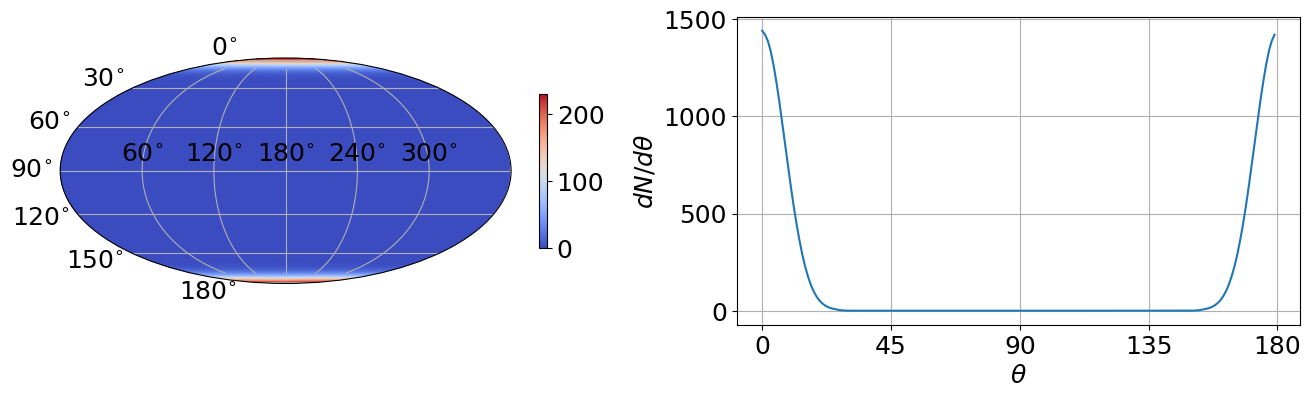

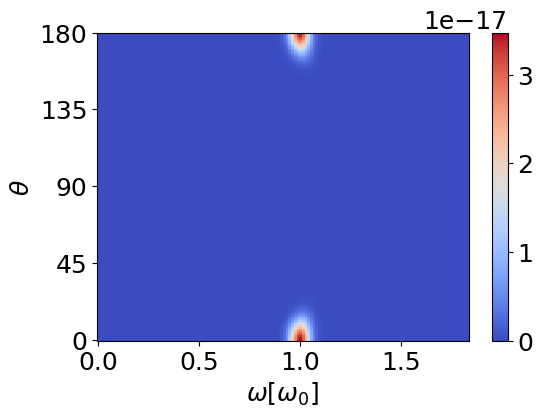

In [9]:
plot_spectra(data_total, "N_sph")

### Polarization-sensitive signal

Polarization-sensitive spectrum has in addition the vectors for field polarization ($\mathbf{e}_f$) and perp polarization ($\mathbf{e}_p$). In this example `optical axis` of 1st beam (which had polarization along x) was chosen for the calculation of perp signal. This corresponds to $\mathbf{e}_f = (1,0,0)$ and $\mathbf{e}_p = (0,1,0)$.

For `local axis` each point in k-space has its own $\mathbf{e}_f, \mathbf{e}_p$ (instead of single number they are given on a grid).

In [10]:
efx, efy, efz = [data_pol[key] for key in "efx efy efz".split()]
print(f"({efx}, {efy}, {efz})")

epx, epy, epz = [data_pol[key] for key in "epx epy epz".split()]
print(f"({epx}, {epy}, {epz})")

(1.0, 0.0, 0.0)
(6.123233995736766e-17, 1.0, 0.0)


One should be careful in the interpretation of the polarization-sensitive spectrum. 

For this example, we calculate perp signal with respect to 1st pulse (propagating along $\mathbf{e}_z: \theta = 0^{\circ}$). We see two peaks in the spectrum corresponding to two pulses, the peak at $\theta = 180^{\circ}$ is not "perp" signal because initially 2nd pulse polarization already contained this mode. So, first, we need to isolate the relevant parts of the spectrum corresponding to the perp signal: here it would be the area corresponding to the 1st pulse $\theta < 90^{\circ}$. Even after that, if initial pulse configuration is a Gaussian then it has a certain bandwidths of modes around the main optical axis, so the perp signal calculation in that way is contaminated by parallel modes.

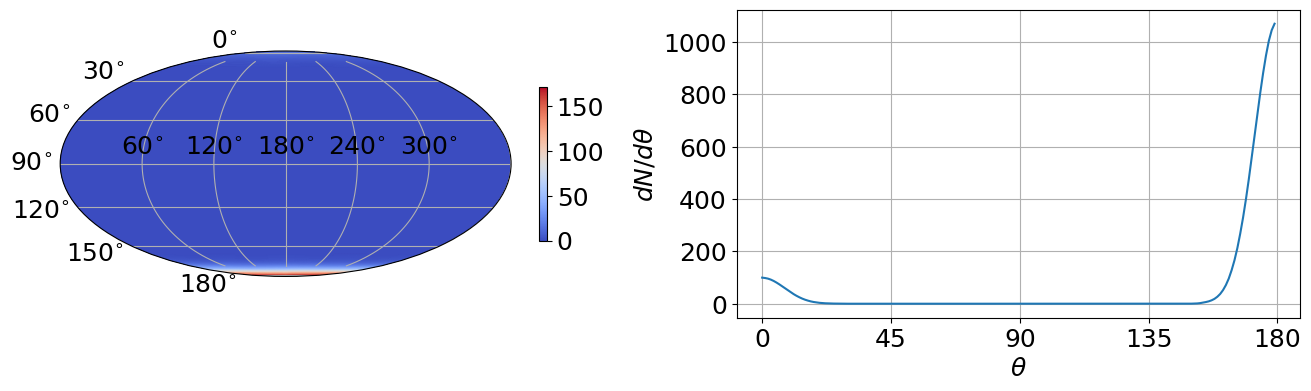

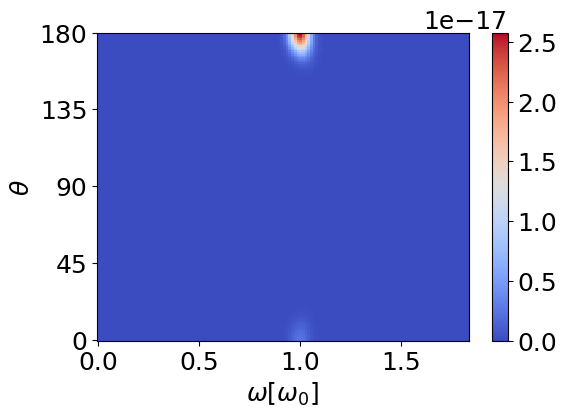

In [11]:
plot_spectra(data_pol, "Np_sph")

### Discernible signal

In [12]:
def plot_discernible(data):
    k, theta, phi, N_sph = [data_total[key] for key in 'k theta phi N_sph'.split()]
    background, discernible, N_disc = [data_total[key] for key in 'background discernible N_disc'.split()]
    N_angular = integrate_spherical(N_sph, (k,theta,phi), axs_integrate=['k'])
    print(f"Discernible signal: {N_disc:.2e}")

    fig = plt.figure(figsize=(26,6))
    ax = plt.subplot(1,3,1, projection='mollweide')
    I0 = N_angular.max()
    norm = mcolors.LogNorm(I0*1e-10, I0)
    plot_mollweide(fig, ax, phi, theta, N_angular, cmap="coolwarm", norm=norm)
    plt.title("signal", loc="center", y=1.1)

    ax = plt.subplot(1,3,2, projection='mollweide')
    I0 = background.max()
    norm = mcolors.LogNorm(I0*1e-10, I0)
    plot_mollweide(fig, ax, phi, theta, background, cmap="coolwarm", norm=norm)
    plt.title("background", loc="center", y=1.1)

    ax = plt.subplot(1,3,3, projection='mollweide')
    plot_mollweide(fig, ax, phi, theta, discernible, cmap="binary")
    plt.title("discernible map", loc="center", y=1.1)
    plt.show()

We see the huge difference in scales between signal photon spectrum and background photon spectrum ($10^1$ vs $10^{22}$). Discernible map is in grey highlighting that no signal is discernible against the background. This is not a surprise since our setup (two counter-propagating gaussians with same frequency and focusing) doesn't allow for any discernible signatures on the total signal level (polarization-insensitive).

We also see that signal spectrum has a slower angular decay than the background. The "spiky" features on the plots are the artefacts of low numerical resolution.

Discernible signal: 0.00e+00


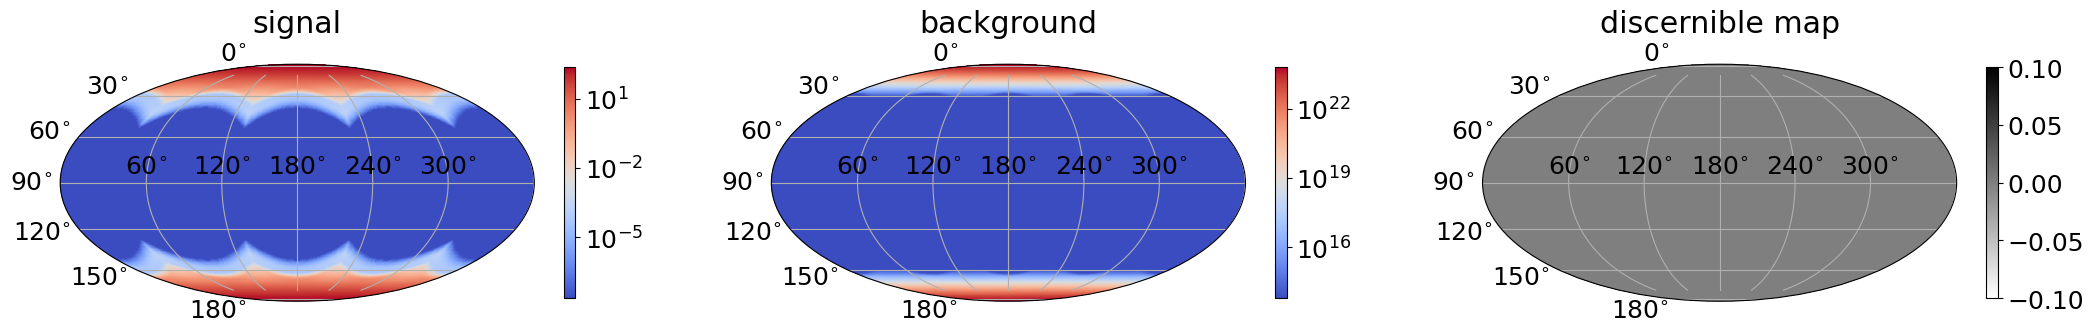

In [13]:
plot_discernible(data_total)